# 생육 기간 예측 프로젝트

## 개요

- 한 쌍의 이미지를 입력 값으로 받아 작물의 생육 기간을 예측하는 모델 개발
  - 현재는 성장 기간 예측만 진행하지만 회차가 진행되며 환경 변수를 추가로 제공할 예정
- <a href='https://dacon.io/competitions/official/235851/overview/description' target='_blink'>데이콘</a> 데이터 사용
  - 훈련용 이미지 : 총 753개
    - 청경채 : 353개
    - 적상추 : 400개
  - 테스트 이미지 : 총 307개
    - 청경채 : 139개
    - 적상추 : 168개
  - 작물별 이미지 2장씩을 조합하여 2장의 이미지간 경과일 기준으로 학습 및 평가 진행
- 모델 평가 기준 : RMSE(Root Mean Squared Error)

## 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 사용 Package 선언

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import transforms
from tqdm.auto import tqdm

import os
import random
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image

## 기본 세팅

#### - seed 고정

In [3]:
# seed 고정
def seed_everything(seed):
  # 파이토치, 넘파이, random 등 관련 모듈의 seed 일괄 설정
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # multi-gpu인 경우
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  
random_seed = 2048
seed_everything(random_seed)

#### - 파일 Path

 - 데이터 경로는 본인의 환경에 맞추어 변경

In [4]:
# 파일 path
train_path = '/content/drive/MyDrive/Colab Notebooks/DL PROJECT/data/train_dataset/'
test_path = '/content/drive/MyDrive/Colab Notebooks/DL PROJECT/data/test_dataset/'
# bc, lt 훈련 데이터 DataFrame path
df_path = '/content/drive/MyDrive/Colab Notebooks/DL PROJECT/data/'
# 모델 checkpoint path
model_path = '/content/drive/MyDrive/Colab Notebooks/DL PROJECT/model/'

#### - 모델 특성

In [5]:
# 모델 특성
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 1e-5
epochs = 10 # 10
batch_size = 40 # 64
valid_batch_size = 40 # 50

## 데이터 관련 함수 정의 및 데이터셋 선언

In [6]:
# 각 파일에서 날짜 추출(Train 데이터)
def extract_day(file_name):
  day = int(file_name.split('.')[-2][-2:])
  return day

In [7]:
# path를 통해 각 파일의 날짜 array 생성
def make_day_array(image_pathes):
  day_array = np.array([extract_day(file_name) for file_name in image_pathes])
  return day_array

In [8]:
# image path array 생성
def make_image_path_array(root_path = None):
  # 디렉토리 확인
  if root_path is None:
    bc_directories = glob('./BC/*')
    lt_directories = glob('./LT/*')
  else:
    bc_directories = glob(root_path + 'BC_RESIZE/*')
    lt_directories = glob(root_path + 'LT_RESIZE/*')
  
  # 각 디렉토리 별 bc 이미지 확인
  bc_image_path = []  # 각 bc 이미지 경로
  bc_dir = []         # 각 bc 이미지 경로가 있는 디렉토리 인덱스
  dir_idx = 0
  for bc_path in bc_directories:
    images = glob(bc_path + '/*.png')
    bc_image_path.extend(images)
    bc_dir.extend(['bc' + str(dir_idx)] * len(images))
    dir_idx += 1
  
  # 각 디렉토리 별 lt 이미지 확인
  lt_image_path = []  # 각 lt 이미지 경로
  lt_dir = []         # 각 lt 이미지 경로가 있는 디렉토리 인덱스
  dir_idx = 0
  for lt_path in lt_directories:
    images = glob(lt_path + '/*.png')
    lt_image_path.extend(images)
    lt_dir.extend(['lt' + str(dir_idx)] * len(images))
    dir_idx += 1

  return bc_image_path, lt_image_path, bc_dir, lt_dir

In [9]:
# 각 이미지별 dataframe 생성
def make_dataframe(root_path=None):
  bc_image_path, lt_image_path, bc_dir, lt_dir = make_image_path_array(root_path)
  bc_day_array = make_day_array(bc_image_path)
  lt_day_array = make_day_array(lt_image_path)

  # 이미지 path와 day를 이용해 생성
  bc_df = pd.DataFrame({"file_name": bc_image_path,
                        "day" : bc_day_array,
                        "dir" : bc_dir})
  # 품종 컬럼 추가
  bc_df['species'] = 'bc'

  # 이미지 path와 day를 이용해 생성
  lt_df = pd.DataFrame({"file_name": lt_image_path,
                        "day" : lt_day_array,
                        "dir" : lt_dir})
  # 품종 컬럼 추가
  lt_df['species'] = 'lt'

  total_data_frame = pd.concat([bc_df, lt_df]).reset_index(drop=True)

  return total_data_frame

In [10]:
# dataframe을 통해 before, after, delta 형식 형성
# 각 디렉토리별 이미지로 모든 경우의 수 생성
def make_combination(species, data_frame):
  before_file_path = []
  after_file_path = []
  time_delta = []

  for dir in tqdm(data_frame[data_frame['species'] == species]['dir'].unique()):
    for i in range(0, len(data_frame[data_frame['dir'] == dir])-1):
      for j in range(0, len(data_frame[data_frame['dir'] == dir])):
        after = data_frame[data_frame['dir'] == dir].iloc[j].reset_index(drop=True)  
        before = data_frame[data_frame['dir'] == dir].iloc[i].reset_index(drop=True)

        if int(after[1]) > int(before[1]):  
          before_file_path.append(before.iloc[0])
          after_file_path.append(after.iloc[0])
          delta = int(after.iloc[1] - before.iloc[1])
          time_delta.append(delta)

  combination_df = pd.DataFrame({
      'before_file_path' : before_file_path,
      'after_file_path' : after_file_path,
      'time_delta' : time_delta,
  })

  combination_df['species'] = species

  return combination_df

In [11]:
# 데이터 설정
class KistDataset(Dataset):
  def __init__(self, combination_df, imgs=None, is_test=None, is_valid=None):
    # Test의 경우 DataFrame 형태
    # 작업시 변환하여 추론
    self.combination_df = combination_df
    # Train, Valid의 경우 numpy 형태로 변환한 형태
    # Image.open과 기본 변환 작업을 건너띈다.
    self.imgs = imgs
    # 텐서 변환
    self.transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # 훈련용 이미지 변환
    self.transform2 = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomAffine((-20, 20)),
      transforms.RandomRotation(90),
    ])
    self.is_test = is_test
    self.is_valid = is_valid
  
  def __getitem__(self, idx):
    if self.is_test:
      before_image = Image.open(self.combination_df.iloc[idx]['before_file_path'])
      after_image = Image.open(self.combination_df.iloc[idx]['after_file_path'])
      before_image = self.transform(before_image)
      after_image = self.transform(after_image)
    else:
      before = self.combination_df.iloc[idx]['before_file_path']
      after = self.combination_df.iloc[idx]['after_file_path']
      before_image = self.imgs[before]
      after_image = self.imgs[after]

    if self.is_test:
      return before_image, after_image
    if self.is_valid == None:
      before_image = self.transform2(before_image)
      after_image = self.transform2(after_image)
    time_delta = self.combination_df.iloc[idx]['time_delta']
    return before_image, after_image, time_delta
  
  def __len__(self):
    return len(self.combination_df)

## 이미지 Resize

- torchvision의 transforms을 통해 resize가 가능하다.
- 하지만, 이미지의 크기가 커서 학습 진행마다 resize하는 시간이 길게 걸린다.
- 따라서, `mobilenet_v2`의 입력 사이즈인 (224, 224)로 훈련, 테스트 데이터를 조절한다.
  - **추후 모델 변경시 입력 사이즈에 맞게 조절한다.**
- 필요에 따라 아래 코드 실행

#### - Resize 디렉토리 생성

In [ ]:
# Train bc_resize 디렉토리
# os.mkdir(train_path+'BC_RESIZE')
# for bc in os.listdir(train_path+'BC/'):
#     os.mkdir(train_path+'BC_RESIZE/'+bc)

In [ ]:
# Train lt_resize 디렉토리
# os.mkdir(train_path+'LT_RESIZE')
# for lt in os.listdir(train_path+'LT/'):
#     os.mkdir(train_path+'LT_RESIZE/'+lt)

In [ ]:
# Test bc_resize 디렉토리
# os.mkdir(test_path+'BC_RESIZE')
# for dir in os.listdir(test_path+'BC/'):
#     os.mkdir(test_path+'BC_RESIZE/'+dir)

In [ ]:
# Test lt_resize 디렉토리
# os.mkdir(test_path+'LT_RESIZE')
# for dir in os.listdir(test_path+'LT/'):
#     os.mkdir(test_path+'LT_RESIZE/'+dir)

#### - Resize 이미지 저장

In [ ]:
# Train bc resize 저장
# for bc in glob(train_path+'BC/*'):
#     bc_num = bc[-5:]
#     print(bc_num)
#     for img in os.listdir(train_path+'BC/'+bc_num):
#         img_re = Image.open(train_path+'BC/'+bc_num+'/'+img)
#         img_re = img_re.resize((224, 224))
#         img_re.save(train_path+'BC_RESIZE/'+bc_num+'/'+img)

In [ ]:
# Train lt resize 저장
# for lt in glob(train_path+'LT/*'):
#     lt_num = lt[-5:]
#     print(lt_num)
#     for img in os.listdir(train_path+'LT/'+lt_num):
#         img_re = Image.open(train_path+'LT/'+lt_num+'/'+img)
#         img_re = img_re.resize((224, 224))
#         img_re.save(train_path+'LT_RESIZE/'+lt_num+'/'+img)

In [ ]:
# Test bc resize 저장
# for dir in os.listdir(test_path+'BC/'):
#     print(dir)
#     for img in os.listdir(test_path+'BC/'+ dir):
#         img_re = Image.open(test_path+'BC/'+dir+'/'+img)
#         img_re = img_re.resize((224, 224))
#         img_re.save(test_path+'BC_RESIZE/'+dir+'/'+img)

In [ ]:
# Test lt resize 저장
# for dir in os.listdir(test_path+'LT/'):
#     print(dir)
#     for img in os.listdir(test_path+'LT/'+ dir):
#         img_re = Image.open(test_path+'LT/'+dir+'/'+img)
#         img_re = img_re.resize((224, 224))
#         img_re.save(test_path+'LT_RESIZE/'+dir+'/'+img)

## 모델 선언 및 학습

### - 모델 구현

- resnext50_32x4d
  - https://pytorch.org/hub/pytorch_vision_resnext/
  - 최소 224 pixel

In [12]:
import torch
from torch import nn
from torchvision.models import resnext50_32x4d

# 이미지를 통해 생육기간 회귀 분석
class CompareCNN(nn.Module):
  def __init__(self):
    super(CompareCNN, self).__init__()
    self.resnext50 = resnext50_32x4d(pretrained=True)
    self.fc_layer = nn.Linear(1000, 1)

  def forward(self, input):
    x = self.resnext50(input)
    output = self.fc_layer(x)
    return output

# before, after 이미지의 생육 기간을 추출해 delta 계산
class CompareNet(nn.Module):
  def __init__(self):
    super(CompareNet, self).__init__()
    self.before_net = CompareCNN()
    self.after_net = CompareCNN()

  def forward(self, before_input, after_input):
    before = self.before_net(before_input)
    after = self.after_net(after_input)
    delta = before - after
    return delta

### - 데이터 준비

- 전체 훈련용 데이터 생성

In [13]:
# 전체 train 이미지 데이터프레임
total_dataframe = make_dataframe(root_path=train_path)
# 청경채 학습 데이터 생성
# bc_combination = make_combination('bc', total_dataframe)
bc_combination = pd.read_csv(df_path+'bc_combination.csv', encoding='utf-8', index_col = 0)
# 적상추 학습 데이터 생성
# lt_combination = make_combination('lt', total_dataframe)
lt_combination = pd.read_csv(df_path+'lt_combination.csv', encoding='utf-8', index_col = 0)

In [14]:
bc_combination.head(1)

,before_file_path,after_file_path,time_delta,species
5533,/content/drive/MyDrive/Colab Notebooks/DL PROJ...,/content/drive/MyDrive/Colab Notebooks/DL PROJ...,18,bc


In [15]:
lt_combination.head(1)

,before_file_path,after_file_path,time_delta,species
3128,/content/drive/MyDrive/Colab Notebooks/DL PROJ...,/content/drive/MyDrive/Colab Notebooks/DL PROJ...,9,lt


- 전체 Train 이미지 : 753개

In [16]:
print(total_dataframe.shape)
total_dataframe.head(2)

(753, 4)


,file_name,day,dir,species
0,/content/drive/MyDrive/Colab Notebooks/DL PROJ...,1,bc0,bc
1,/content/drive/MyDrive/Colab Notebooks/DL PROJ...,2,bc0,bc


- 각 이미지를 미리 불러와 저장한다.
- 각 Train 이미지의 텐서 변환, 정규화를 진행한다.

In [17]:
# 기본 텐서 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
imgs = {}

# before, after 이미지 변환 및 리스트에 추가
for idx, row in tqdm(total_dataframe.iterrows()):
    img = Image.open(row['file_name'])
    
    img = transform(img)

    imgs[row['file_name']] = img
    
len(imgs), imgs[total_dataframe['file_name'][0]].shape

0it [00:00, ?it/s]

(753, torch.Size([3, 224, 224]))

- 청경채 6812개, 적상추 7801개
- 총 14613개

In [18]:
bc_combination.shape, lt_combination.shape, len(bc_combination) + len(lt_combination)

((6812, 4), (7801, 4), 14613)

- 데이터를 sample을 통해 무작위로 섞어준다.

In [ ]:
# csv 파일을 읽으므로 주석 처리
# bc_combination = bc_combination.sample(len(bc_combination), random_state=random_seed)
# lt_combination = lt_combination.sample(len(lt_combination), random_state=random_seed)

- bc, lt 전체 데이터 csv 파일로 저장
  - 파일 생성 시간을 단축하기 위함

In [ ]:
# csv 파일을 읽으므로 주석 처리
# bc_combination.to_csv('bc_combination.csv', encoding='utf-8')
# lt_combination.to_csv('lt_combination.csv', encoding='utf-8')

- Train : Validation = 0.9 : 0.1
  - 청경채(bc) : Train(6132 개), Valid(680 개)
  - 적상추(lt) : Train(7021 개), Valid(780 개)
  - Train DataSet : 13153 개
  - Valid DataSet : 1460 개

In [19]:
# train, valid 구분
bc_train = bc_combination.iloc[:6132]
bc_valid = bc_combination.iloc[6132:]

# train, valid 구분
lt_train = lt_combination.iloc[:7201]
lt_valid = lt_combination.iloc[7201:]

# 학습 train, valid 데이터 연결
train_set = pd.concat([bc_train, lt_train])
valid_set = pd.concat([bc_valid, lt_valid])


# 학습 train, valid 데이터 데이터셋으로 변경
train_dataset = KistDataset(train_set, imgs)
valid_dataset = KistDataset(valid_set, imgs, is_valid=True)

# DataLoader 선언
train_data_loader = DataLoader(train_dataset,
                               batch_size = batch_size,
                               shuffle = True)
valid_data_loader = DataLoader(valid_dataset,
                               batch_size = valid_batch_size)

#### - 모델 구성

In [20]:
# 모델 선언
model = CompareNet().to(device)
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=lr)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
# 학습 재개를 위한 체크포인트 불러오기
# model_state = torch.load(model_path + 'checkpoint_128().pt', 
#                          map_location=torch.device(device))

# model.load_state_dict(model_state['model'])
# optimizer.load_state_dict(model_state['optim'])

### - 모델 학습

In [21]:
for epoch in tqdm(range(epochs)):
  for step, (before_image, after_image, time_delta) in tqdm(enumerate(train_data_loader)):
    before_image = before_image.to(device)
    after_image = after_image.to(device)
    time_delta = time_delta.to(device)

    optimizer.zero_grad()
    logit = model(before_image, after_image)
    train_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - time_delta.float())) / torch.LongTensor([batch_size]).squeeze(0).to(device))
    train_loss.backward()
    optimizer.step()

    if step % 15 == 0:
      print('\n=====================loss=====================')
      print(f'\n=====================EPOCH:{epoch}=====================')
      print(f'\n=====================step:{step}=====================')
      print('MAE_loss : ', train_loss.detach().cpu().numpy())
  
  valid_losses = []
  with torch.no_grad():
    for valid_before, valid_after, time_delta in tqdm(valid_data_loader):
      valid_before = valid_before.to(device)
      valid_after = valid_after.to(device)
      valid_time_delta = time_delta.to(device)

      logit = model(valid_before, valid_after)
      valid_loss = (torch.sum(torch.abs(logit.squeeze(1).float() - valid_time_delta.float())) / torch.LongTensor([valid_batch_size]).squeeze(0).to(device))
      valid_losses.append(valid_loss.detach().cpu())
  
  print(f'VALIDATION_LOSS MAE : {sum(valid_losses)/len(valid_losses)}')
  checkpoint = {
        'model': model.state_dict(),
        'optim' : optimizer.state_dict()
  }
  torch.save(checkpoint, 'checkpoint_128_{}.pt'.format(epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:0=====================

=====================step:0=====================
MAE_loss :  14.620512

=====================loss=====================

=====================EPOCH:0=====================

=====================step:15=====================
MAE_loss :  9.3444

=====================loss=====================

=====================EPOCH:0=====================

=====================step:30=====================
MAE_loss :  10.787827

=====================loss=====================

=====================EPOCH:0=====================

=====================step:45=====================
MAE_loss :  4.938567

=====================loss=====================

=====================EPOCH:0=====================

=====================step:60=====================
MAE_loss :  4.4517593

=====================loss=====================

=====================EPOCH:0=====================

=====================step:75=================

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 2.4545602798461914


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:1=====================

=====================step:0=====================
MAE_loss :  1.5505455

=====================loss=====================

=====================EPOCH:1=====================

=====================step:15=====================
MAE_loss :  2.3590252

=====================loss=====================

=====================EPOCH:1=====================

=====================step:30=====================
MAE_loss :  2.1020136

=====================loss=====================

=====================EPOCH:1=====================

=====================step:45=====================
MAE_loss :  1.8303162

=====================loss=====================

=====================EPOCH:1=====================

=====================step:60=====================
MAE_loss :  1.3756542

=====================loss=====================

=====================EPOCH:1=====================

=====================step:75=============

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 2.2027475833892822


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:2=====================

=====================step:0=====================
MAE_loss :  2.0511968

=====================loss=====================

=====================EPOCH:2=====================

=====================step:15=====================
MAE_loss :  1.4829955

=====================loss=====================

=====================EPOCH:2=====================

=====================step:30=====================
MAE_loss :  3.0711014

=====================loss=====================

=====================EPOCH:2=====================

=====================step:45=====================
MAE_loss :  1.7005333

=====================loss=====================

=====================EPOCH:2=====================

=====================step:60=====================
MAE_loss :  2.45946

=====================loss=====================

=====================EPOCH:2=====================

=====================step:75===============

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 2.2470650672912598


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:3=====================

=====================step:0=====================
MAE_loss :  1.302832

=====================loss=====================

=====================EPOCH:3=====================

=====================step:15=====================
MAE_loss :  1.9076458

=====================loss=====================

=====================EPOCH:3=====================

=====================step:30=====================
MAE_loss :  1.5842564

=====================loss=====================

=====================EPOCH:3=====================

=====================step:45=====================
MAE_loss :  2.9815524

=====================loss=====================

=====================EPOCH:3=====================

=====================step:60=====================
MAE_loss :  1.3654276

=====================loss=====================

=====================EPOCH:3=====================

=====================step:75==============

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 1.9719557762145996


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:4=====================

=====================step:0=====================
MAE_loss :  1.3668184

=====================loss=====================

=====================EPOCH:4=====================

=====================step:15=====================
MAE_loss :  1.7482479

=====================loss=====================

=====================EPOCH:4=====================

=====================step:30=====================
MAE_loss :  2.484445

=====================loss=====================

=====================EPOCH:4=====================

=====================step:45=====================
MAE_loss :  1.3855252

=====================loss=====================

=====================EPOCH:4=====================

=====================step:60=====================
MAE_loss :  1.450853

=====================loss=====================

=====================EPOCH:4=====================

=====================step:75===============

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 1.8510546684265137


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:5=====================

=====================step:0=====================
MAE_loss :  1.0360183

=====================loss=====================

=====================EPOCH:5=====================

=====================step:15=====================
MAE_loss :  1.578469

=====================loss=====================

=====================EPOCH:5=====================

=====================step:30=====================
MAE_loss :  1.4151897

=====================loss=====================

=====================EPOCH:5=====================

=====================step:45=====================
MAE_loss :  1.0917256

=====================loss=====================

=====================EPOCH:5=====================

=====================step:60=====================
MAE_loss :  1.0891566

=====================loss=====================

=====================EPOCH:5=====================

=====================step:75==============

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 1.8198870420455933


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:6=====================

=====================step:0=====================
MAE_loss :  0.97466123

=====================loss=====================

=====================EPOCH:6=====================

=====================step:15=====================
MAE_loss :  1.3239896

=====================loss=====================

=====================EPOCH:6=====================

=====================step:30=====================
MAE_loss :  1.6834186

=====================loss=====================

=====================EPOCH:6=====================

=====================step:45=====================
MAE_loss :  0.9734844

=====================loss=====================

=====================EPOCH:6=====================

=====================step:60=====================
MAE_loss :  0.99716794

=====================loss=====================

=====================EPOCH:6=====================

=====================step:75===========

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 1.7311173677444458


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:7=====================

=====================step:0=====================
MAE_loss :  0.9329071

=====================loss=====================

=====================EPOCH:7=====================

=====================step:15=====================
MAE_loss :  1.0742042

=====================loss=====================

=====================EPOCH:7=====================

=====================step:30=====================
MAE_loss :  1.8137

=====================loss=====================

=====================EPOCH:7=====================

=====================step:45=====================
MAE_loss :  1.8820484

=====================loss=====================

=====================EPOCH:7=====================

=====================step:60=====================
MAE_loss :  0.8859402

=====================loss=====================

=====================EPOCH:7=====================

=====================step:75================

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 1.909258246421814


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:8=====================

=====================step:0=====================
MAE_loss :  1.2894695

=====================loss=====================

=====================EPOCH:8=====================

=====================step:15=====================
MAE_loss :  1.7140694

=====================loss=====================

=====================EPOCH:8=====================

=====================step:30=====================
MAE_loss :  1.0520623

=====================loss=====================

=====================EPOCH:8=====================

=====================step:45=====================
MAE_loss :  0.9669369

=====================loss=====================

=====================EPOCH:8=====================

=====================step:60=====================
MAE_loss :  0.97448456

=====================loss=====================

=====================EPOCH:8=====================

=====================step:75============

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 1.6832005977630615


0it [00:00, ?it/s]


=====================loss=====================

=====================EPOCH:9=====================

=====================step:0=====================
MAE_loss :  0.8800577

=====================loss=====================

=====================EPOCH:9=====================

=====================step:15=====================
MAE_loss :  0.8726783

=====================loss=====================

=====================EPOCH:9=====================

=====================step:30=====================
MAE_loss :  1.8182404

=====================loss=====================

=====================EPOCH:9=====================

=====================step:45=====================
MAE_loss :  1.7806904

=====================loss=====================

=====================EPOCH:9=====================

=====================step:60=====================
MAE_loss :  2.502437

=====================loss=====================

=====================EPOCH:9=====================

=====================step:75==============

  0%|          | 0/32 [00:00<?, ?it/s]

VALIDATION_LOSS MAE : 1.663884162902832


## 결과 추론

### - 테스트 데이터 준비

In [22]:
test_set = pd.read_csv(test_path + 'test_data.csv')
test_set['l_root'] = test_set['before_file_path'].map(lambda x : test_path + x.split('_')[1] + '_RESIZE/' + x.split('_')[2])
test_set['r_root'] = test_set['after_file_path'].map(lambda x : test_path + x.split('_')[1] + '_RESIZE/' + x.split('_')[2])
test_set['before_file_path'] = test_set['l_root'] + '/' + test_set['before_file_path'] + '.png'
test_set['after_file_path'] = test_set['r_root'] + '/' + test_set['after_file_path'] + '.png'
test_dataset = KistDataset(test_set, is_test = True)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

### - 테스트 데이터 추론

In [23]:
test_value = []
with torch.no_grad():
  for test_before, test_after in tqdm(test_data_loader):
    test_before = test_before.to(device)
    test_after = test_after.to(device)
    logit = model(test_before, test_after)
    value = logit.squeeze(1).detach().cpu().float()

    test_value.extend(value)

  0%|          | 0/99 [00:00<?, ?it/s]

In [24]:
len(test_value), test_value[:5]

(3960,
 [tensor(29.1584),
  tensor(34.4975),
  tensor(6.7728),
  tensor(3.5640),
  tensor(27.4923)])

- 결과는 간단하게 numpy.array형태로 저장해둔다.

In [25]:
test_value = np.array(test_value)

In [26]:
np.save('test_value.npy', test_value)

In [27]:
t = np.load('test_value.npy')

In [28]:
t[:5], test_value[:5]

(array([29.158375 , 34.49751  ,  6.7727594,  3.563951 , 27.492302 ],
       dtype=float32),
 array([29.158375 , 34.49751  ,  6.7727594,  3.563951 , 27.492302 ],
       dtype=float32))

## 추가 관찰

- 조금 더 추가가 필요
- 현재는 mobilenetV2 버전을 사용한 [checkpoint_128(211226).pt] 사용
- before_net의 features 레이어의 결과인 [1280, 7, 7] 이미지로 표현

### - 데이터 준비

In [29]:
# 전체 train 이미지 데이터프레임
total_dataframe = make_dataframe(root_path=train_path)

In [30]:
# 기본 텐서 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
imgs = {}

# before, after 이미지 변환 및 리스트에 추가
for idx, row in tqdm(total_dataframe.iterrows()):
    img = Image.open(row['file_name'])
    
    img = transform(img)

    imgs[row['file_name']] = img

len(imgs), imgs[total_dataframe['file_name'][0]].shape

0it [00:00, ?it/s]

(753, torch.Size([3, 224, 224]))

### - 모델 연결

#### 모델 구현

In [31]:
import torch
from torch import nn
from torchvision.models import mobilenet_v2

# 이미지를 통해 생육기간 회귀 분석
class CompareCNN(nn.Module):
  def __init__(self):
    super(CompareCNN, self).__init__()
    self.mobile_net = mobilenet_v2(pretrained=True)
    self.fc_layer = nn.Linear(1000, 1)

  def forward(self, input):
    x = self.mobile_net(input)
    output = self.fc_layer(x)
    return output

# before, after 이미지의 생육 기간을 추출해 delta 계산
class CompareNet(nn.Module):
  def __init__(self):
    super(CompareNet, self).__init__()
    self.before_net = CompareCNN()
    self.after_net = CompareCNN()

  def forward(self, before_input, after_input):
    before = self.before_net(before_input)
    after = self.after_net(after_input)
    delta = before - after
    return delta

#### 모델 선언

In [32]:
# 모델 선언
model = CompareNet().to(device)

# 학습 재개를 위한 체크포인트 불러오기
# CPU, GPU에 따라 오류가 발생하므로
# 초기화한 device 변수를 통해 mapping
model_state = torch.load(model_path + 'checkpoint_128(211226).pt', 
                         map_location=torch.device(device))

model.load_state_dict(model_state['model'])

# before_net의 특성 추출 부분인 features만 사용
# features가 첫 부분이므로 해당 부분만 사용해도 된다.
mobile_model = model.before_net.mobile_net.features
del model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### - Feature Map

#### 특징 추출

In [39]:
# 이미지 1개 선택
# 추론을 위해 unsqueeze를 통해 차원 추가
img = imgs[total_dataframe['file_name'][30]].unsqueeze(0)
img = img.to(device)
# before_net의 features만 진행한 결과
# 이미지로 출력하기 위해 squeeze를 통해 차원 축소
value = mobile_model(img).squeeze(0)

#### 원본 이미지

In [40]:
import matplotlib.pyplot as plt

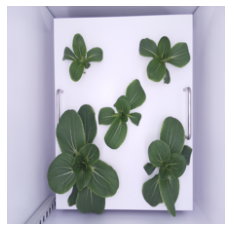

In [41]:
# 원본 이미지를 출력
img_original = Image.open(total_dataframe['file_name'][30])
plt.imshow(img_original)
plt.axis('off')
plt.show()

#### Feature Map

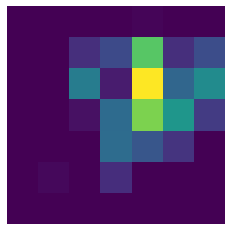

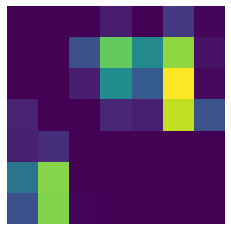

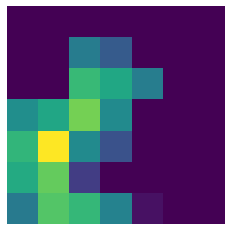

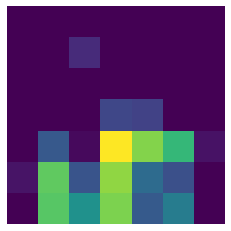

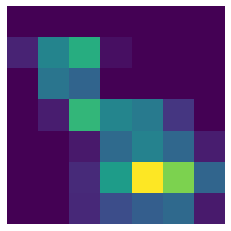

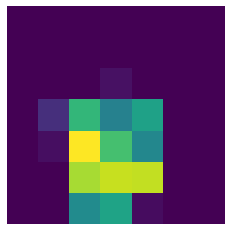

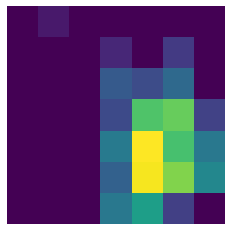

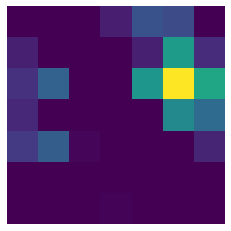

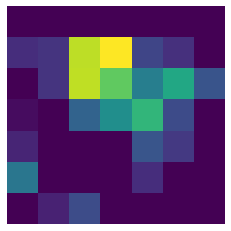

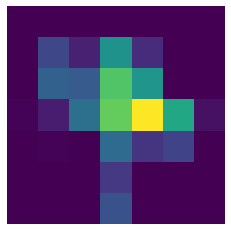

In [43]:
for idx, feature in enumerate(value, start=1):
    plt.imshow(feature.cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    if idx == 10:
        break